In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import copy
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC


In [47]:
cl_name=[name[17:] for name in glob.glob('../edit/training/*')]
cl_name=dict(zip(range(0,len(cl_name)), cl_name))
print (cl_name)

#load the image from dataset
def load_images(path, num_per_class=-1):
    data = []
    labels = []
    for id, class_name in cl_name.items():
        im_path = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            im_path = im_path[:num_per_class]
        labels.extend([id]*len(im_path))
        for filename in im_path:
            data.append(cv2.imread(filename, 0))
    return data, labels
# compute dense SIFT 
def SIFT(data):
    temp=[]
    for i in range(0, len(data)):
        sift=cv2.SIFT_create()
        img=data[i]
        kp=[cv2.KeyPoint(temp, y, 15) for temp in range(0, img.shape[0], 15) for y in range(0, img.shape[1], 15)]
        dense_feat=sift.compute(img, kp)
        temp.append(dense_feat[1])    
    return temp

# # build BoW presentation from SIFT of training images 
def vocabulary(all, k):
    kmeans = KMeans(n_clusters=k,random_state=0).fit(all)
    return kmeans


# form training set histograms for each training image using BoW representation
def Train_Hist(x_train, kmeans, k):
    train_hist=[]
    for i in range(len(x_train)):
        data=copy.deepcopy(x_train[i])
        predict=kmeans.predict(data)
        train_hist.append(np.bincount(predict, minlength=k).reshape(1,-1).ravel())   
    r=np.array(train_hist)
    return r

# train model
def train(data, labels, k):
    neighbors=KNeighborsClassifier(n_neighbors=k,p=2)
    neighbors.fit(data,labels) 
    return neighbors

# build histograms for test set and predict
def predict(kmeans, scaler, x_test, train_hist, train_label, k):
    test_hist = Train_Hist(x_test, kmeans, k)
    test_hist = scaler.transform(test_hist)
    knn = train(train_hist, train_label, k)
    predict = knn.predict(test_hist)
    return np.array([predict], dtype=np.array([test_label]).dtype)
#model accuracy
def accuracy(predict_label, test_label):
    acc = np.mean(np.array(predict_label.tolist()[0]) == np.array(test_label))
    return acc




{0: 'Forest', 1: 'bedroom', 2: 'Office', 3: 'Highway', 4: 'Coast', 5: 'Insidecity', 6: 'TallBuilding', 7: 'industrial', 8: 'Street', 9: 'livingroom', 10: 'Suburb', 11: 'Mountain', 12: 'kitchen', 13: 'OpenCountry', 14: 'store'}


In [48]:
# load training dataset
train_data, train_label = load_images('../edit/training/')
train_num = len(train_label)

# load testing dataset
test_data, test_label = load_images('../edit/testing/')
test_num = len(test_label)
# extract dense sift features from training images


x_train = SIFT(train_data)
x_test = SIFT(test_data)
train_all = []
for i in range(len(x_train)):
    for j in range(x_train[i].shape[0]):
        train_all.append(x_train[i][j,:])

train_all = np.array(train_all)

In [49]:
k = [80]
for i in range(len(k)):
    kmeans = vocabulary(train_all, k[i])
    train_hist = Train_Hist(x_train, kmeans, k[i])
    scaler = preprocessing.StandardScaler().fit(train_hist)
    train_hist = scaler.transform(train_hist)
    predict = predict(kmeans, scaler, x_test, train_hist, train_label, k[i])
    res = accuracy(predict, test_label)
    print("k =", k[i], ", Accuracy:", res*100, "%")

k = 80 , Accuracy: 55.55555555555556 %


In [27]:
k = 80
kmeans = KMeans(n_clusters=k,random_state=0).fit(train_all)
# form training and testing histograms
train_hist = Train_Hist(x_train, kmeans, k)
test_hist = Train_Hist(x_test, kmeans, k)

In [28]:
# normalize histograms
scaler = preprocessing.StandardScaler().fit(train_hist)
train_hist = scaler.transform(train_hist)
test_hist = scaler.transform(test_hist)

In [29]:
for c in np.arange(0.0001, 0.1, 0.00198):
    clf = LinearSVC(random_state=0, C=c)
    clf.fit(train_hist, train_label)
    predict = clf.predict(test_hist)
    print ("C =", c, ",\t Accuracy:", np.mean(predict == test_label)*100, "%")
    #print ("Accuracy:", np.mean(predict == test_label)*100, "%")

C = 0.0001 ,	 Accuracy: 56.2962962962963 %
C = 0.00208 ,	 Accuracy: 62.96296296296296 %
C = 0.00406 ,	 Accuracy: 62.96296296296296 %
C = 0.00604 ,	 Accuracy: 65.18518518518519 %
C = 0.00802 ,	 Accuracy: 66.66666666666666 %
C = 0.009999999999999998 ,	 Accuracy: 65.92592592592592 %
C = 0.01198 ,	 Accuracy: 65.92592592592592 %
C = 0.01396 ,	 Accuracy: 65.92592592592592 %
C = 0.01594 ,	 Accuracy: 65.92592592592592 %
C = 0.01792 ,	 Accuracy: 65.18518518518519 %
C = 0.019899999999999998 ,	 Accuracy: 65.92592592592592 %
C = 0.02188 ,	 Accuracy: 65.92592592592592 %
C = 0.02386 ,	 Accuracy: 65.92592592592592 %
C = 0.02584 ,	 Accuracy: 65.92592592592592 %
C = 0.02782 ,	 Accuracy: 65.92592592592592 %
C = 0.0298 ,	 Accuracy: 65.92592592592592 %
C = 0.03178 ,	 Accuracy: 65.92592592592592 %
C = 0.033760000000000005 ,	 Accuracy: 65.92592592592592 %
C = 0.03574 ,	 Accuracy: 64.44444444444444 %
C = 0.037720000000000004 ,	 Accuracy: 64.44444444444444 %
C = 0.0397 ,	 Accuracy: 65.18518518518519 %
C = 0.0

ValueError: The number of FixedLocator locations (15), usually from a call to set_ticks, does not match the number of ticklabels (2).

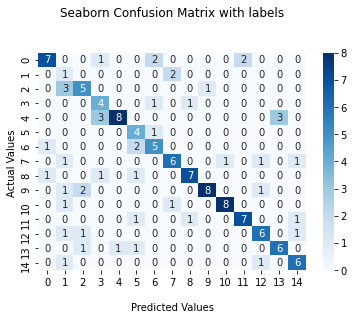

In [30]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(predict, test_label)
import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

###  Spatial Pyramid Matching

In [94]:
import math

def extract_denseSIFT(img):
    DSIFT_STEP_SIZE = 2
    sift = cv2.SIFT_create()
    disft_step_size = DSIFT_STEP_SIZE
    keypoints = [cv2.KeyPoint(x, y, disft_step_size)
            for y in range(0, img.shape[0], disft_step_size)
                for x in range(0, img.shape[1], disft_step_size)]
    descriptors = sift.compute(img, keypoints)[1]
    return descriptors

def getImageFeaturesSPM(L, img, kmeans, k):
    W = img.shape[1]
    H = img.shape[0]   
    h = []
    for l in range(L+1):
        w_step = math.floor(W/(2**l))
        h_step = math.floor(H/(2**l))
        x, y = 0, 0
        for i in range(1,2**l + 1):
            x = 0
            for j in range(1, 2**l + 1):                
                desc = extract_denseSIFT(img[y:y+h_step, x:x+w_step])                
                predict = kmeans.predict(desc)
                histo = np.bincount(predict, minlength=k).reshape(1,-1).ravel()
                weight = 2**(l-L)
                h.append(weight*histo)
                x = x + w_step
            y = y + h_step  
    hist = np.array(h).ravel()
    dev = np.std(hist)
    hist -= np.mean(hist)
    hist /= dev
    return hist
# get histogram representation for training/testing data
def getHistogramSPM(L, data, kmeans, k):    
    x = []
    for i in range(len(data)):        
        hist = getImageFeaturesSPM(L, data[i], kmeans, k)        
        x.append(hist)
    return np.array(x)

In [98]:
k = 200
kmeans = KMeans(n_clusters=k,random_state=0).fit(train_all)

In [99]:
train_histo = getHistogramSPM(2, train_data, kmeans, k)
test_histo = getHistogramSPM(2, test_data, kmeans, k)

In [100]:
# train SVM
for c in np.arange(0.000307, 0.001, 0.0000462):
    clf1 = LinearSVC(random_state=0, C=0.0008151999999999999)
    clf1.fit(train_histo, train_label)
    predict1 = clf1.predict(test_histo)
    print ("C =", c, ",\t\t Accuracy:", np.mean(predict1 == test_label)*100, "%")

C = 0.000307 ,		 Accuracy: 66.66666666666666 %
C = 0.00035319999999999997 ,		 Accuracy: 66.66666666666666 %
C = 0.00039939999999999995 ,		 Accuracy: 66.66666666666666 %
C = 0.00044559999999999993 ,		 Accuracy: 66.66666666666666 %
C = 0.0004917999999999999 ,		 Accuracy: 66.66666666666666 %
C = 0.0005379999999999998 ,		 Accuracy: 66.66666666666666 %
C = 0.0005841999999999999 ,		 Accuracy: 66.66666666666666 %
C = 0.0006303999999999999 ,		 Accuracy: 66.66666666666666 %
C = 0.0006765999999999999 ,		 Accuracy: 66.66666666666666 %
C = 0.0007227999999999998 ,		 Accuracy: 66.66666666666666 %
C = 0.0007689999999999998 ,		 Accuracy: 66.66666666666666 %
C = 0.0008151999999999999 ,		 Accuracy: 66.66666666666666 %
C = 0.0008613999999999998 ,		 Accuracy: 66.66666666666666 %
C = 0.0009075999999999997 ,		 Accuracy: 66.66666666666666 %
C = 0.0009537999999999998 ,		 Accuracy: 66.66666666666666 %
C = 0.0009999999999999998 ,		 Accuracy: 66.66666666666666 %


ValueError: The number of FixedLocator locations (15), usually from a call to set_ticks, does not match the number of ticklabels (2).

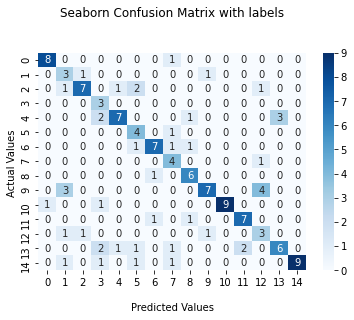

In [101]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(predict1, test_label)
import seaborn as sns
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()